# Testing on gamma + proton and testing on protons

In this notebook, we do not only focus on gamma rays, but also on the proton showers. We did this by also training on protons, and testing on protons.

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

**Preperation of training data**

In [4]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])
data_target_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    data_noisy_chunk = np.array(data_noisy_all[0])
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
    data_target_chunk = np.array(data_noisy_all[1])
    data_target_tot = np.append(data_target_tot, data_target_chunk)
    
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(128*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(128*chunk_tot, 56, 56)
data_target = data_target_tot.reshape(128*chunk_tot)

In [5]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 12800


In [6]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((128*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_target_arr = data_target[images_high_mask]

data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]

data_target_test = data_target_arr[idx_split:]

data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==1]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==1]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]

data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==1]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==1]


**Defining model and fitting functions**

In [7]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        x = x.reshape(1, 56*56)
        
        return x         

In [8]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [9]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

**Train Gamma+Proton --> Test Gamma**

First run is to give a general impression of the performance of the model

In [10]:
%%time

n_epochs = 15

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.6822
IOU: 0.13478225469589233
Training set: Avg. loss: 0.1384

Test set: Avg. loss: 0.0849
IOU: 0.4490985572338104
Training set: Avg. loss: 0.1155

Test set: Avg. loss: 0.0745
IOU: 0.4775241017341614
Training set: Avg. loss: 0.1115

Test set: Avg. loss: 0.0727
IOU: 0.48893097043037415
Training set: Avg. loss: 0.1090

Test set: Avg. loss: 0.0738
IOU: 0.4877699017524719
Training set: Avg. loss: 0.1073

Test set: Avg. loss: 0.0707
IOU: 0.49626973271369934
Training set: Avg. loss: 0.1063

Test set: Avg. loss: 0.0743
IOU: 0.49381741881370544
Training set: Avg. loss: 0.1055

Test set: Avg. loss: 0.0743
IOU: 0.4873921871185303
Training set: Avg. loss: 0.1051

Test set: Avg. loss: 0.0698
IOU: 0.5004860162734985
Training set: Avg. loss: 0.1049

Test set: Avg. loss: 0.0701
IOU: 0.49203139543533325
Training set: Avg. loss: 0.1038

Test set: Avg. loss: 0.0712
IOU: 0.4994869828224182
Training set: Avg. loss: 0.1035

Test set: Avg. loss: 0.0714
IOU: 0.4975392520427704
Trainin

In [11]:
print(IOU_list)

[tensor(0.1348), tensor(0.4491), tensor(0.4775), tensor(0.4889), tensor(0.4878), tensor(0.4963), tensor(0.4938), tensor(0.4874), tensor(0.5005), tensor(0.4920), tensor(0.4995), tensor(0.4975), tensor(0.4956), tensor(0.4670), tensor(0.4953), tensor(0.4855)]


**Train Gamma+Proton --> Test Proton**

In [13]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((128*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_target_arr = data_target[images_high_mask]
#pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
#pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
#data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

#data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]

data_target_test = data_target_arr[idx_split:]

data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==0]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]

data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==0]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==0]


In [14]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [15]:
%%time

n_epochs = 15

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.6532
IOU: 0.1085064634680748
Training set: Avg. loss: 0.1357

Test set: Avg. loss: 0.1273
IOU: 0.3686339259147644
Training set: Avg. loss: 0.1153

Test set: Avg. loss: 0.1179
IOU: 0.4050106108188629
Training set: Avg. loss: 0.1117

Test set: Avg. loss: 0.1180
IOU: 0.40545353293418884
Training set: Avg. loss: 0.1087

Test set: Avg. loss: 0.1152
IOU: 0.408880352973938
Training set: Avg. loss: 0.1080

Test set: Avg. loss: 0.1172
IOU: 0.4036885201931
Training set: Avg. loss: 0.1066

Test set: Avg. loss: 0.1151
IOU: 0.4113141596317291
Training set: Avg. loss: 0.1060

Test set: Avg. loss: 0.1142
IOU: 0.41499295830726624
Training set: Avg. loss: 0.1051

Test set: Avg. loss: 0.1144
IOU: 0.416393905878067
Training set: Avg. loss: 0.1047

Test set: Avg. loss: 0.1143
IOU: 0.41679978370666504
Training set: Avg. loss: 0.1040

Test set: Avg. loss: 0.1153
IOU: 0.4184698164463043
Training set: Avg. loss: 0.1035

Test set: Avg. loss: 0.1155
IOU: 0.41227367520332336
Training set:

In [16]:
print(IOU_list)

[tensor(0.1085), tensor(0.3686), tensor(0.4050), tensor(0.4055), tensor(0.4089), tensor(0.4037), tensor(0.4113), tensor(0.4150), tensor(0.4164), tensor(0.4168), tensor(0.4185), tensor(0.4123), tensor(0.4178), tensor(0.4140), tensor(0.4167), tensor(0.4168)]


**Train Gamma --> Test Proton**

In [17]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((128*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_target_arr = data_target[images_high_mask]

data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing

data_target_train = data_target_arr[:idx_split]
data_noisy_train = data_noisy_tensor[:idx_split][data_target_train==1]
data_true_train = data_true_tensor[:idx_split][data_target_train==1]

data_target_test = data_target_arr[idx_split:]

data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==0]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split][data_target_train==1]
data_true_train_im = data_true_tensor_im[:idx_split][data_target_train==1]

data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==0]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==0]


In [18]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [19]:
%%time

n_epochs = 15

learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.9294
IOU: 0.03802790492773056
Training set: Avg. loss: 0.1304

Test set: Avg. loss: 0.1283
IOU: 0.3694254159927368
Training set: Avg. loss: 0.0967

Test set: Avg. loss: 0.1302
IOU: 0.3845348656177521
Training set: Avg. loss: 0.0911

Test set: Avg. loss: 0.1197
IOU: 0.3993445634841919
Training set: Avg. loss: 0.0873

Test set: Avg. loss: 0.1207
IOU: 0.4006996154785156
Training set: Avg. loss: 0.0853

Test set: Avg. loss: 0.1190
IOU: 0.40649694204330444
Training set: Avg. loss: 0.0825

Test set: Avg. loss: 0.1199
IOU: 0.40716472268104553
Training set: Avg. loss: 0.0812

Test set: Avg. loss: 0.1205
IOU: 0.40806564688682556
Training set: Avg. loss: 0.0802

Test set: Avg. loss: 0.1251
IOU: 0.40701544284820557
Training set: Avg. loss: 0.0791

Test set: Avg. loss: 0.1229
IOU: 0.39964476227760315
Training set: Avg. loss: 0.0785

Test set: Avg. loss: 0.1188
IOU: 0.4086666703224182
Training set: Avg. loss: 0.0776

Test set: Avg. loss: 0.1214
IOU: 0.40733981132507324
Train

In [20]:
print(IOU_list)

[tensor(0.0380), tensor(0.3694), tensor(0.3845), tensor(0.3993), tensor(0.4007), tensor(0.4065), tensor(0.4072), tensor(0.4081), tensor(0.4070), tensor(0.3996), tensor(0.4087), tensor(0.4073), tensor(0.4027), tensor(0.3966), tensor(0.4028), tensor(0.4059)]


In [25]:
# IoUs for all different situations (copy pasted from the outcomes of the fits earlier in the notebook)

# Train: Gamma, Test: Gamma
IOU_gg = np.array([0.01266847, 0.40483007, 0.4549535, 0.4735601, 0.48056817, 0.48420948,
                   0.48993102, 0.49143583, 0.491041, 0.49168363, 0.492882, 0.4883904,
                   0.49142233, 0.49202985, 0.49059168, 0.4922339])

# Train: Gamma+Proton, Test: Gamma
IOU_gpg = np.array([0.1348, 0.4491, 0.4775, 0.4889, 0.4878, 0.4963, 0.4938, 0.4874, 0.5005, 
                    0.4920, 0.4995, 0.4975, 0.4956, 0.4670, 0.4953, 0.4855])


# Train: Gamma, Test: Proton
IOU_gp = np.array([0.0380, 0.3694, 0.3845, 0.3993, 0.4007, 0.4065, 0.4072, 0.4081, 0.4070, 
                    0.3996, 0.4087, 0.4073, 0.4027, 0.3966, 0.4028, 0.4059])

# Train: Gamma+Proton, Test: Proton
IOU_gpp = np.array([0.1085, 0.3686, 0.4050, 0.4055, 0.4089, 0.4037, 0.4113, 0.4150, 0.4164, 
                    0.4168, 0.4185, 0.4123, 0.4178, 0.4140, 0.4167, 0.4168])




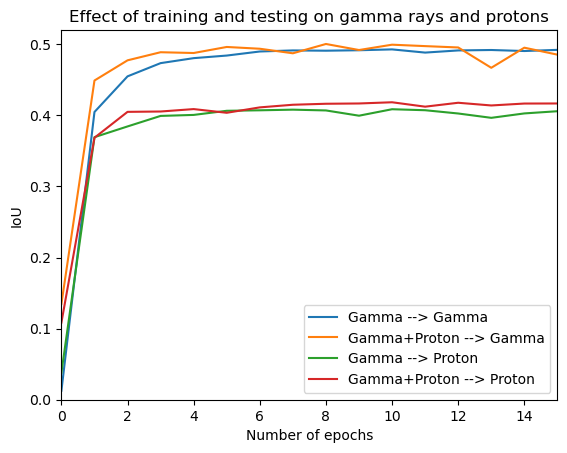

In [29]:
fig_gamma_proton = plt.figure()

plt.title("Effect of training and testing on gamma rays and protons")
plt.plot(test_counter, IOU_gg, label='Gamma --> Gamma')
plt.plot(test_counter, IOU_gpg, label='Gamma+Proton --> Gamma')
plt.plot(test_counter, IOU_gp, label='Gamma --> Proton')
plt.plot(test_counter, IOU_gpp, label='Gamma+Proton --> Proton')
plt.xlim(0,n_epochs)
plt.ylim(0,0.52)
plt.xlabel("Number of epochs")
plt.ylabel("IoU")
plt.legend()

plt.show()

fig_gamma_proton.savefig("images/gammaproton_segmentation.pdf")

**Some examples**

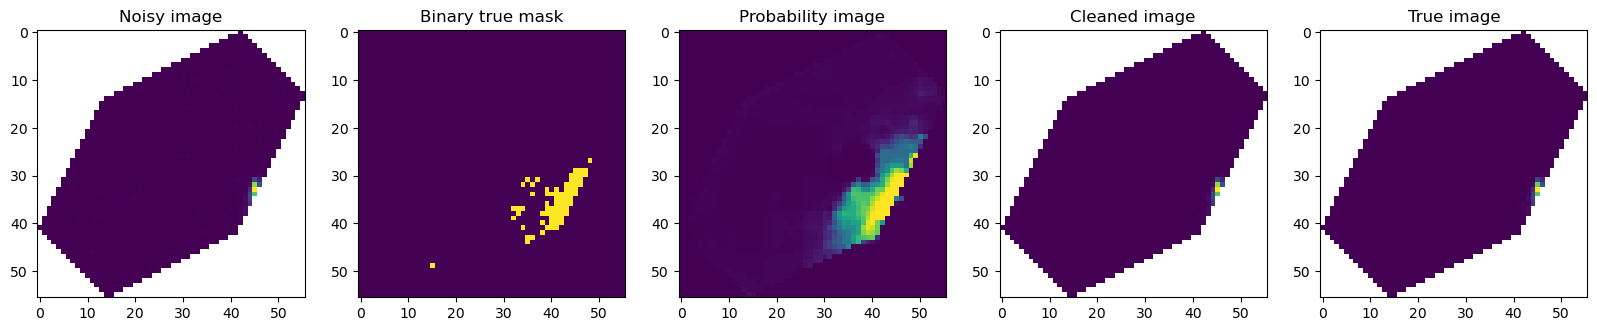

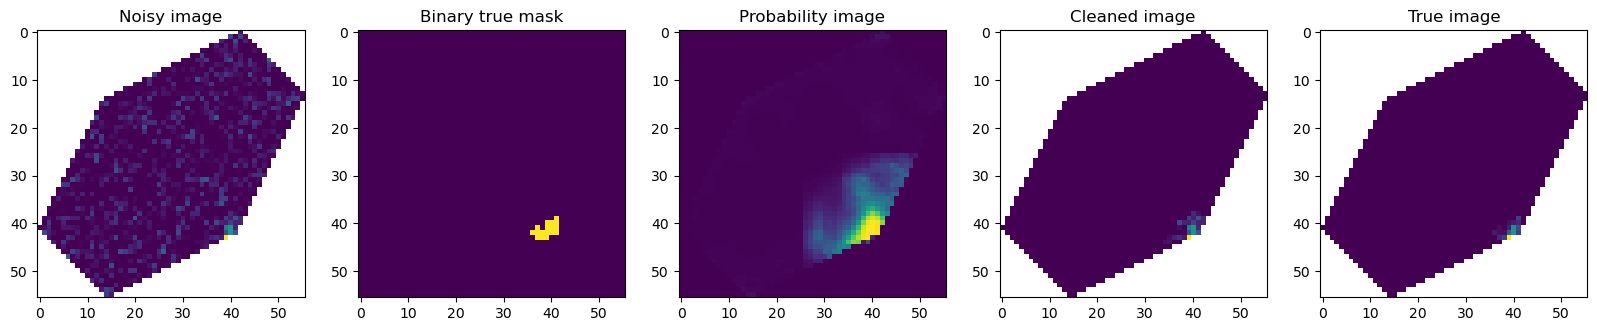

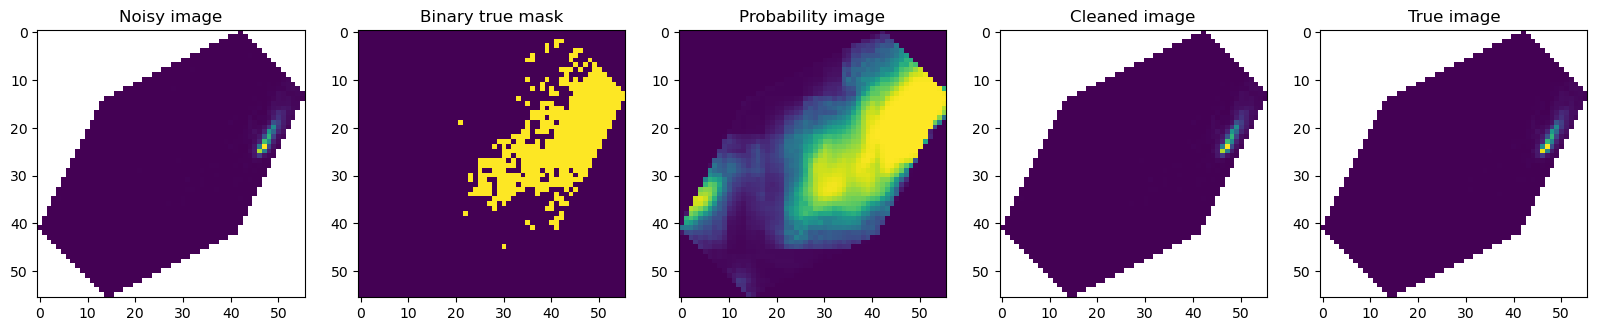

In [27]:
n_start = 0
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))
    output = F.sigmoid(output)
    im_clean = output.reshape(1, 56, 56)
    im_clean_prob = im_clean.detach()[0].numpy()

    im_clean = im_clean_prob.round()
    mask_clean = im_clean.astype(bool)
    im_clean_good = np.zeros((56,56))

    im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean_good[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,5,figsize=(20,10))

    axs[0].imshow(data_noisy_test_im[im_i], vmin=0)
    axs[0].set_title("Noisy image")
    
    axs[1].imshow((data_true_binary[images_high_mask])[idx_split+im_i])
    axs[1].set_title("Binary true mask")
    
    fig_clean_prob = axs[2].imshow(im_clean_prob, vmin=0)
    axs[2].set_title("Probability image")

    axs[3].imshow(im_clean_good, vmin=0)
    axs[3].set_title("Cleaned image")

    axs[4].imshow(data_true_test_im[im_i], vmin=0)
    axs[4].set_title("True image")

plt.show()    